_This notebook contains code and comments from Section 7.2 of the book [Ensemble Methods for Machine Learning](https://www.manning.com/books/ensemble-methods-for-machine-learning). Please see the book for additional details on this topic. This notebook and code are released under the [MIT license](https://github.com/gkunapuli/ensemble-methods-notebooks/blob/master/LICENSE)._

## 7.2	Parallel Ensembles for Regression

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

### 7.2.1 Random Forests & ExtraTrees for Regression
In this section, we look at two classical parallel ensemble methods for regression: Random Forests and ExtraTrees. We use the AutoMPG data set, which is a classical benchmark data set for regression.

In [2]:
# # Load the data from the UCI repository, clean it and save it as a CSV file
# url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
# column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
#                 'Acceleration', 'Model Year', 'Origin']

# data = pd.read_csv(url, names=column_names, na_values='?', comment='\t', sep=' ', skipinitialspace=True)
# data = data.dropna()
# data.to_csv('./data/ch07/autompg.csv', index=False)

**Listing 7.2**: Loading and pre-processing the AutoMPG data set

In [3]:
# Load the AutoMPG data set from the data folder
data = pd.read_csv('./data/ch07/autompg.csv')
data.describe()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
count,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000
mean,23.445918,5.471939,194.411990,104.469388,2977.584184,15.541327,75.979592,1.576531
std,7.805007,1.705783,104.644004,38.491160,849.402560,2.758864,3.683737,0.805518
min,9.000000,3.000000,68.000000,46.000000,1613.000000,8.000000,70.000000,1.000000
25%,17.000000,4.000000,105.000000,75.000000,2225.250000,13.775000,73.000000,1.000000
50%,22.750000,4.000000,151.000000,93.500000,2803.500000,15.500000,76.000000,1.000000
75%,29.000000,8.000000,275.750000,126.000000,3614.750000,17.025000,79.000000,2.000000
max,46.600000,8.000000,455.000000,230.000000,5140.000000,24.800000,82.000000,3.000000


In [4]:
# Get indices for the features and labels
labels = data.columns.get_loc('MPG')
features = np.setdiff1d(np.arange(0, len(data.columns), 1), labels)

# Split into train and test sets
from sklearn.model_selection import train_test_split
trn, tst = train_test_split(data, test_size=0.2, random_state=42)

# Split into features and labels
from sklearn.preprocessing import StandardScaler
preprocessor = StandardScaler().fit(trn)
trn, tst = preprocessor.transform(trn), preprocessor.transform(tst)
Xtrn, ytrn = trn[:, features], trn[:, labels]
Xtst, ytst = tst[:, features], tst[:, labels]

**Listing 7.3**: Random Forest and ExtraTrees for Regression

In [5]:
# Train several ML models
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

ensembles = {'Random Forest MSE': RandomForestRegressor(criterion='mse'),
             'Random Forest MAE': RandomForestRegressor(criterion='mae'),
             'ExtraTrees MSE': ExtraTreesRegressor(criterion='mse'),
             'ExtraTrees MAE': ExtraTreesRegressor(criterion='mae')}

results = pd.DataFrame()
ypred_trn = {}
ypred_tst = {}

for method, ensemble in ensembles.items():
    ensemble.fit(Xtrn, ytrn)
    ypred_trn[method] = ensemble.predict(Xtrn)
    ypred_tst[method] = ensemble.predict(Xtst)
    res = {'Package-Method-Loss': method, 
            'Train MSE': mean_squared_error(ytrn, ypred_trn[method]),
            'Train MAE': mean_absolute_error(ytrn, ypred_trn[method]), 
            'Test MSE': mean_squared_error(ytst, ypred_tst[method]),
            'Test MAE': mean_absolute_error(ytst, ypred_tst[method])}
    results = results.append(res, ignore_index=True)

In [6]:
pd.options.display.float_format = '{:,.4f}'.format
print(results)

  Package-Method-Loss  Test MAE  Test MSE  Train MAE  Train MSE
0   Random Forest MSE    0.2173    0.0938     0.0924     0.0175
1   Random Forest MAE    0.2222    0.0911     0.0982     0.0204
2      ExtraTrees MSE    0.1978    0.0757     0.0000     0.0000
3      ExtraTrees MAE    0.2005    0.0733     0.0000     0.0000


### 7.2.2 Combining Predictions for Regression
The predictions of several regression models (such as those trained above) can be combined / ensembled into a final prediction. Since many of the individual models that we combine here are themselves ensembles, we end up with an _ensemble of ensembles_.

First, we use combining functions such as mean, median, max, min.

**Listing 7.4**: Aggregators for Continuous-Valued Labels

In [7]:
agg_methods = ['Mean', 'Median', 'Max', 'Min']
aggregators = [np.mean, np.median, np.max, np.min]

results = pd.DataFrame()
ypred_trn_values = np.array(list(ypred_trn.values()))
ypred_tst_values = np.array(list(ypred_tst.values()))

for method, aggregate in zip(agg_methods, aggregators):
    yagg_trn = aggregate(ypred_trn_values, axis=0)
    yagg_tst = aggregate(ypred_tst_values, axis=0)
    
    res = {'Aggregator': method, 
            'Train MSE': mean_squared_error(ytrn, yagg_trn),
            'Train MAE': mean_absolute_error(ytrn, yagg_trn), 
            'Test MSE': mean_squared_error(ytst, yagg_tst),
            'Test MAE': mean_absolute_error(ytst, yagg_tst)}
    results = results.append(res, ignore_index=True)

In [8]:
print(results)

  Aggregator  Test MAE  Test MSE  Train MAE  Train MSE
0       Mean    0.2069    0.0800     0.0471     0.0046
1     Median    0.2041    0.0784     0.0399     0.0036
2        Max    0.2260    0.0990     0.0542     0.0090
3        Min    0.2017    0.0754     0.0565     0.0145


Next, we can stack these predictions with a second-level learner (or meta-learner). We'll use an artificial neural network as a meta learner here.

**Listing 7.5**: Stacking regression models

In [9]:
from sklearn.ensemble import StackingRegressor
from sklearn.neural_network import MLPRegressor

from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.gaussian_process import GaussianProcessRegressor


estimators = [('Kernel Ridge Regression', KernelRidge(kernel='rbf', gamma=0.1)), 
              ('Support Vector Machine', SVR(kernel='rbf', gamma=0.1)),
              ('K-Nearest Neighbors', KNeighborsRegressor(n_neighbors=3)),
              ('ExtraTrees', ExtraTreesRegressor(n_estimators=50, criterion='mae'))]

meta_learner = MLPRegressor(hidden_layer_sizes=(50, 50, 50), max_iter=1000)

stack = StackingRegressor(estimators, final_estimator=meta_learner, cv=3)
stack.fit(Xtrn, ytrn);

In [10]:
ypred_trn = stack.predict(Xtrn)
ypred_tst = stack.predict(Xtst)

print('Train MSE = {0:5.4f}, Train MAE = {1:5.4f}\n' \
      'Test MSE = {2:5.4f}, Test MAE = {3:5.4f}'.format(
      mean_squared_error(ytrn, ypred_trn),
      mean_absolute_error(ytrn, ypred_trn),
      mean_squared_error(ytst, ypred_tst),
      mean_absolute_error(ytst, ypred_tst)))

Train MSE = 0.0469, Train MAE = 0.1499
Test MSE = 0.0831, Test MAE = 0.2177


---
## 7.3 Sequential Ensembles for Regression

In regression problems, residuals convey two important pieces of information to the base learners. The magnitude of the residual of each training example indicates the extent of the error in fitting, while the sign of the residual indicates whether the model is under or overestimating.

The loss function and, more importantly, its derivatives allow us to measure the residual between the current model’s prediction and the true label. By changing the loss function, we are essentially changing how we prioritize different examples.

Both gradient boosting and Newton boosting use shallow regression trees as weak base learners to fit residuals and approximate the gradient of the loss function.

### 7.3.1 Loss Functions for Regression

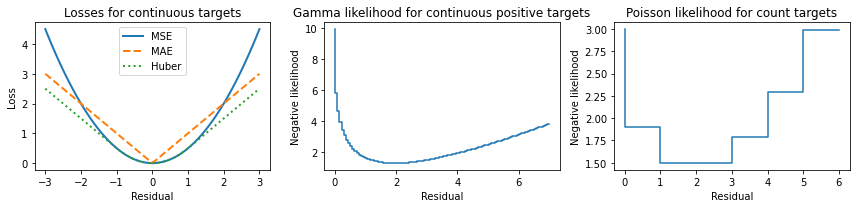

In [11]:
import scipy
from scipy.stats import poisson, gamma

def mse(x):
    return 0.5 * x**2

def huber(x):
    return scipy.special.huber(1., x)
    

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 3))

xx = np.linspace(-3., 3., num=100)
losses = [mse, np.abs, huber]
styles = ['-', '--', ':']

for style, loss in zip(styles, losses):
    ax[0].plot(xx, loss(xx), linestyle=style, linewidth=2)
ax[0].set_xlabel('Residual')
ax[0].set_ylabel('Loss')
ax[0].set_title('Losses for continuous targets')
ax[0].legend(['MSE', 'MAE', 'Huber'])


xx = np.linspace(0.01, 7., num=100)
dist = gamma(a=3, loc=0., scale=1)
yy = -np.log(dist.pdf(xx))
ax[1].step(xx, yy)
ax[1].set_xlabel('Residual')
ax[1].set_ylabel('Negative likelihood')
ax[1].set_title('Gamma likelihood for continuous positive targets')

xx = np.arange(0, 7)
dist = poisson(3)
yy = -np.log(dist.pmf(xx))
ax[2].step(xx, yy)
ax[2].set_xlabel('Residual')
ax[2].set_ylabel('Negative likelihood')
ax[2].set_title('Poisson likelihood for count targets')

fig.tight_layout()
pngFile = './figures/CH07_F10_Kunapuli.png'
plt.savefig(pngFile, dpi=300, bbox_inches='tight', pad_inches=0.05)

### 7.3.2 LightGBM and XGBoost for Regression

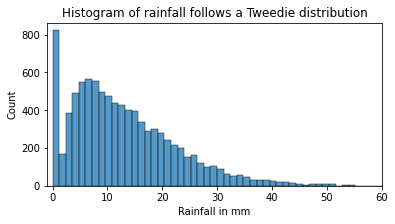

In [12]:
import tweedie
import seaborn as sns

samples = tweedie.tweedie(mu=12, p=1.2, phi=5).rvs(10000)
samples = np.concatenate((samples[samples > 0], np.zeros((800, ))))

fig, ax = plt.subplots(figsize=(6, 3))
sns.histplot(samples, ax=ax)
plt.xlabel('Rainfall in mm');
plt.title('Histogram of rainfall follows a Tweedie distribution')
plt.xlim(-1, 60)
pngFile = './figures/CH07_F11_Kunapuli.png'
plt.savefig(pngFile, dpi=300, bbox_inches='tight', pad_inches=0)

**Listing 7.6**. Using LightGBM with Huber Loss

In [13]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import RandomizedSearchCV

parameters = {'alpha': [0.3, 0.9, 1.8],
              'max_depth': np.arange(2, 5, step=1), 
              'learning_rate': 2**np.arange(-8., 2., step=2),
              'subsample': [0.6, 0.7, 0.8],
              'lambda_l1': [0.01, 0.1, 1],
              'lambda_l2': [0.01, 0.1, 1e-1, 1]}

lgb = LGBMRegressor(objective='huber', n_estimators=100)
param_tuner = RandomizedSearchCV(lgb, parameters, n_iter=20, cv=5, refit=True, verbose=1)
param_tuner.fit(Xtrn, ytrn, eval_set=[(Xtst, ytst)], eval_metric='mse', verbose=False)

ypred_trn = param_tuner.best_estimator_.predict(Xtrn)
ypred_tst = param_tuner.best_estimator_.predict(Xtst)
print('Train MSE = {0:5.4f}, Train MAE = {1:5.4f}\n' \
      'Test MSE = {2:5.4f}, Test MAE = {3:5.4f}'.format(
      mean_squared_error(ytrn, ypred_trn), mean_absolute_error(ytrn, ypred_trn),
      mean_squared_error(ytst, ypred_tst), mean_absolute_error(ytst, ypred_tst)))

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Train MSE = 0.0418, Train MAE = 0.1461
Test MSE = 0.0930, Test MAE = 0.2252


**Listing 7.7**. Using XGBoost with pseudo-Huber Loss

In [14]:
from xgboost import XGBRegressor

parameters = {'max_depth': np.arange(2, 5, step=1), 
              'learning_rate': 2**np.arange(-8., 2., step=2),
              'colsample_bytree': [0.6, 0.7, 0.8],
              'reg_alpha': [0.01, 0.1, 1],
              'reg_lambda': [0.01, 0.1, 1e-1, 1]}

xgb = XGBRegressor(objective='reg:pseudohubererror')
param_tuner = RandomizedSearchCV(xgb, parameters, n_iter=20, cv=5, refit=True, verbose=1)
param_tuner.fit(Xtrn, ytrn, eval_set=[(Xtst, ytst)], eval_metric='rmse', verbose=False)

ypred_trn = param_tuner.best_estimator_.predict(Xtrn)
ypred_tst = param_tuner.best_estimator_.predict(Xtst)
print('Train MSE = {0:5.4f}, Train MAE = {1:5.4f}\n' \
      'Test MSE = {2:5.4f}, Test MAE = {3:5.4f}'.format(
      mean_squared_error(ytrn, ypred_trn), mean_absolute_error(ytrn, ypred_trn),
      mean_squared_error(ytst, ypred_tst), mean_absolute_error(ytst, ypred_tst)))

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Train MSE = 0.0507, Train MAE = 0.1643
Test MSE = 0.0960, Test MAE = 0.2281
